# Laboratorio 2 (ISIS-2611) — Preparación y limpieza base de datos

Este notebook deja **todo listo** para arrancar el Laboratorio 2 (búsqueda de hiperparámetros, complejidad, validación cruzada, bootstrapping), siguiendo el estilo de las **Prácticas** del repositorio:

- Pipelines con `Pipeline` + `ColumnTransformer`
- Imputación y escalamiento *dentro* del pipeline (evita leakage)
- Separación clara: **limpieza determinística** vs **transformaciones aprendidas**

> **Qué hace este notebook**
> 1) Carga train/test del Lab 1 desde el repositorio (auto-detección de rutas)  
> 2) Limpieza base (determinística): normaliza strings, parsea Blood Pressure, convierte numéricos, elimina nulos del target, quita duplicados exactos  
> 3) Prepara `X_train`, `y_train`, `X_test` (sin leakage)  
> 4) Guarda versiones `processed/` (opcional)  
> 5) Hace un **sanity check** con un modelo baseline (LinearRegression + preprocesamiento)

--- 


In [48]:
# 0) Imports y configuración


import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, r2_score



## 1) Localizar y cargar los datos (auto-detección)

El repositorio suele tener los datos en:

- `Laboratorios/L1 Regresion Lineal/data/Datos Lab 1.csv`
- `Laboratorios/L1 Regresion Lineal/data/Datos Test Lab 1.csv`

Como a veces el notebook corre desde otra carpeta (p.ej. Lab 2), hacemos una función que busca esos archivos hacia arriba en el árbol de directorios.


In [49]:


train = "./data/Datos Lab 1.csv"
test = "./data/Datos Test Lab 1.csv"

print("Train:", train)
print("Test :", test)

df_train_raw = pd.read_csv(train)
df_test_raw = pd.read_csv(test, sep=";")

print("\nShapes raw:")
print("df_train_raw:", df_train_raw.shape)
print("df_test_raw :", df_test_raw.shape)

df_train_raw.head(3)


Train: ./data/Datos Lab 1.csv
Test : ./data/Datos Test Lab 1.csv

Shapes raw:
df_train_raw: (1639, 24)
df_test_raw : (194, 22)


,Patient ID,Date of Service,Sex,Age,Weight (kg),Height (m),BMI,Abdominal Circumference (cm),Blood Pressure (mmHg),Total Cholesterol (mg/dL),...,Physical Activity Level,Family History of CVD,Height (cm),Waist-to-Height Ratio,Systolic BP,Diastolic BP,Blood Pressure Category,Estimated LDL (mg/dL),CVD Risk Score,CVD Risk Level
0,isDx5313,"November 08, 2023",M,44.0,114.300,1.720,38.600,100.000,112/83,228.0,...,High,N,172.000,0.581,112.0,83.0,Hypertension Stage 1,121.0,19.880,HIGH
1,LHCK2961,20/03/2024,F,57.0,92.923,1.842,33.116,106.315,101/91,158.0,...,High,Y,184.172,0.577,101.0,91.0,Hypertension Stage 2,57.0,16.833,INTERMEDIARY
2,WjVn1699,2021-05-27,F,NaN,73.400,1.650,27.000,78.100,90/74,135.0,...,High,N,165.000,0.473,90.0,74.0,Normal,45.0,12.600,LOW


## 2) Checklist rápido de calidad (antes de limpiar)

Solo para tener una foto rápida (completitud + duplicados).


In [50]:
def missing_report(df: pd.DataFrame) -> pd.DataFrame:
    out = pd.DataFrame({
        "n_null": df.isna().sum(),
        "%_null": (df.isna().mean() * 100).round(2),
        "dtype": df.dtypes.astype(str),
    }).sort_values("%_null", ascending=False)
    return out

print("Duplicados exactos (train):", df_train_raw.duplicated().sum())
print("Patient ID duplicados (train):", df_train_raw["Patient ID"].duplicated().sum() if "Patient ID" in df_train_raw.columns else "N/A")

missing_report(df_train_raw).head(12)


Duplicados exactos (train): 151
Patient ID duplicados (train): 263


,n_null,%_null,dtype
Diastolic BP,85,5.19,float64
HDL (mg/dL),82,5.00,float64
Waist-to-Height Ratio,76,4.64,float64
Weight (kg),73,4.45,float64
Total Cholesterol (mg/dL),68,4.15,float64
Age,68,4.15,float64
Height (cm),68,4.15,float64
Height (m),61,3.72,float64
Abdominal Circumference (cm),61,3.72,float64
Systolic BP,61,3.72,float64


## 3) Limpieza base (determinística)

Objetivo: **dejar el dataset consistente** sin meter lógica “aprendida” (imputación/escalado) por fuera del pipeline.

### Reglas que aplicamos
- Normalización de strings: `strip()` + `upper()` en columnas categóricas
- Parse de `Blood Pressure (mmHg)` si viene como `"120/80"`  
  - Se usa para completar `Systolic BP` y `Diastolic BP` cuando falten
- Conversión robusta a numérico en columnas numéricas (con `errors='coerce'`)
- Eliminación de filas con `CVD Risk Score` nulo en train (target)
- Eliminación de duplicados exactos (filas idénticas)

> **Importante:** No imputamos aquí. Eso se hace en los pipelines del Lab 2 (como en las Prácticas).


In [51]:
TARGET = "CVD Risk Score"

CATEGORICAL_COLS = [
    "Sex",
    "Smoking Status",
    "Diabetes Status",
    "Physical Activity Level",
    "Family History of CVD",
    "Blood Pressure Category",
]

NUMERIC_COLS = [
    "Age",
    "Weight (kg)",
    "Height (m)",
    "BMI",
    "Abdominal Circumference (cm)",
    "Total Cholesterol (mg/dL)",
    "HDL (mg/dL)",
    "Fasting Blood Sugar (mg/dL)",
    "Height (cm)",
    "Waist-to-Height Ratio",
    "Systolic BP",
    "Diastolic BP",
    "Estimated LDL (mg/dL)",
]

def normalize_strings(df: pd.DataFrame, cols: list[str]) -> pd.DataFrame:
    df = df.copy()
    for c in cols:
        if c in df.columns:
            df[c] = (
                df[c]
                .astype("string")
                .str.strip()
                .str.upper()
                .str.replace(r"\s+", " ", regex=True)
            )
    return df

def parse_bp(df: pd.DataFrame, bp_col: str = "Blood Pressure (mmHg)") -> pd.DataFrame:
    """Extrae sistólica/diastólica desde '120/80' cuando exista."""
    df = df.copy()
    if bp_col not in df.columns:
        return df

    s = df[bp_col].astype("string")
    # Extrae números tipo 120/80 (permite espacios)
    extracted = s.str.extract(r"(?P<sys>\d{2,3})\s*/\s*(?P<dia>\d{2,3})")
    df["Systolic BP_parsed"] = pd.to_numeric(extracted["sys"], errors="coerce")
    df["Diastolic BP_parsed"] = pd.to_numeric(extracted["dia"], errors="coerce")
    return df

def merge_bp(df: pd.DataFrame) -> pd.DataFrame:
    """Completa Systolic/Diastolic con los *_parsed cuando falten."""
    df = df.copy()
    for base, parsed in [("Systolic BP", "Systolic BP_parsed"), ("Diastolic BP", "Diastolic BP_parsed")]:
        if base in df.columns and parsed in df.columns:
            df[base] = pd.to_numeric(df[base], errors="coerce")
            df[base] = df[base].fillna(df[parsed])
    return df

def coerce_numeric(df: pd.DataFrame, cols: list[str]) -> pd.DataFrame:
    df = df.copy()
    for c in cols:
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors="coerce")
    return df

def base_clean_train_test(df_train: pd.DataFrame, df_test: pd.DataFrame) -> tuple[pd.DataFrame, pd.DataFrame]:
    # 1) Normalizar categóricas (consistencia)
    df_train = normalize_strings(df_train, CATEGORICAL_COLS + ["CVD Risk Level"])
    df_test  = normalize_strings(df_test,  CATEGORICAL_COLS)

    # 2) Parse/merge Blood Pressure
    df_train = merge_bp(parse_bp(df_train))
    df_test  = merge_bp(parse_bp(df_test))

    # 3) Coerción numérica
    df_train = coerce_numeric(df_train, NUMERIC_COLS + [TARGET])
    df_test  = coerce_numeric(df_test,  NUMERIC_COLS)

    # 4) Completitud: remover nulos en el target (solo train)
    if TARGET in df_train.columns:
        df_train = df_train.dropna(subset=[TARGET])

    # 5) Duplicados exactos
    df_train = df_train.drop_duplicates()
    df_test  = df_test.drop_duplicates()

    return df_train, df_test

df_train_clean, df_test_clean = base_clean_train_test(df_train_raw, df_test_raw)

print("Shapes clean:")
print("df_train_clean:", df_train_clean.shape)
print("df_test_clean :", df_test_clean.shape)

df_train_clean.head(3)


Shapes clean:
df_train_clean: (1460, 26)
df_test_clean : (189, 24)


,Patient ID,Date of Service,Sex,Age,Weight (kg),Height (m),BMI,Abdominal Circumference (cm),Blood Pressure (mmHg),Total Cholesterol (mg/dL),...,Height (cm),Waist-to-Height Ratio,Systolic BP,Diastolic BP,Blood Pressure Category,Estimated LDL (mg/dL),CVD Risk Score,CVD Risk Level,Systolic BP_parsed,Diastolic BP_parsed
0,isDx5313,"November 08, 2023",M,44.0,114.300,1.720,38.600,100.000,112/83,228.0,...,172.000,0.581,112.0,83.0,HYPERTENSION STAGE 1,121.0,19.880,HIGH,112,83
1,LHCK2961,20/03/2024,F,57.0,92.923,1.842,33.116,106.315,101/91,158.0,...,184.172,0.577,101.0,91.0,HYPERTENSION STAGE 2,57.0,16.833,INTERMEDIARY,101,91
2,WjVn1699,2021-05-27,F,NaN,73.400,1.650,27.000,78.100,90/74,135.0,...,165.000,0.473,90.0,74.0,NORMAL,45.0,12.600,LOW,90,74


## 4) Preparar `X_train`, `y_train`, `X_test` (sin leakage)

- Se elimina `CVD Risk Level` **por defecto** (es derivada del target; mejor no tocarla en Lab 2)
- Se eliminan identificadores y fecha (a menos que el profe explícitamente pida ingeniería de features temporal)

Si necesitas *conservar* algo para análisis, hazlo en una copia, pero **no lo metas al pipeline** por accidente.


In [52]:
DROP_ALWAYS = ["Patient ID", "Date of Service", "CVD Risk Level", "Blood Pressure (mmHg)", "Systolic BP_parsed", "Diastolic BP_parsed"]

X_train = df_train_clean.drop(columns=DROP_ALWAYS + [TARGET], errors="ignore")
y_train = df_train_clean[TARGET].astype(float)

X_test  = df_test_clean.drop(columns=DROP_ALWAYS, errors="ignore")

print("X_train:", X_train.shape, "| y_train:", y_train.shape)
print("X_test :", X_test.shape)

# Checks rápidos
assert set(X_train.columns) == set(X_test.columns), "Train/test no tienen las mismas columnas"
print("✅ Mismas columnas en train y test")

X_train.isna().mean().sort_values(ascending=False).head(10)


X_train: (1460, 19) | y_train: (1460,)
X_test : (189, 19)
✅ Mismas columnas en train y test


HDL (mg/dL)                     0.050000
Waist-to-Height Ratio           0.046575
Weight (kg)                     0.045205
Total Cholesterol (mg/dL)       0.042466
Height (cm)                     0.041781
Age                             0.041096
Height (m)                      0.036301
Estimated LDL (mg/dL)           0.034932
Abdominal Circumference (cm)    0.034247
Fasting Blood Sugar (mg/dL)     0.032877
dtype: float64

## 5) Guardar versiones `processed/` (opcional)

Esto te sirve para que el notebook principal del Lab 2 sea más corto:
- Cargas `X_train.csv`, `y_train.csv`, `X_test.csv`
- Construyes pipelines + GridSearchCV encima

> Si no quieres guardar nada, puedes saltarte esta sección.


In [53]:
from pathlib import Path


PROCESSED_DIR = Path.cwd() / "data" / "processed"
PROCESSED_DIR.mkdir(parents=True, exist_ok=True)

(df_train_clean).to_csv(PROCESSED_DIR / "train_clean_base.csv", index=False)
(df_test_clean ).to_csv(PROCESSED_DIR / "test_clean_base.csv", index=False)

X_train.to_csv(PROCESSED_DIR / "X_train.csv", index=False)
y_train.to_csv(PROCESSED_DIR / "y_train.csv", index=False)
X_test.to_csv(PROCESSED_DIR / "X_test.csv", index=False)

print("Guardado en:", PROCESSED_DIR.resolve())


Guardado en: C:\Users\juanb\MaterialDeClase-ISIS-2611-1\Laboratorios\L2 Complejidad y búsqueda de hiperparámetros\data\processed


## Listo ✅

A partir de aquí, en tu notebook principal del Lab 2 puedes:

1) Cargar `X_train`, `y_train` y construir los pipelines con `GridSearchCV`  
2) Generar curvas de validación (grado del polinomio vs error CV)  
3) Comparar modelos (sin regularización, Ridge, Lasso, polinomial+regularización)  
4) Seleccionar el mejor por **promedio** y **desviación estándar** en CV  
5) Bootstrapping en tu conjunto de test (≥ 500 remuestreos) para intervalos de confianza

--- 

Si quieres, te puedo generar el notebook completo del Lab 2 encima de estas mismas variables (con las 7 actividades).


Inicio del laboratorio 2

1. Se construye el modelo de regresión polinomial, justificando las decisiones tomadas.

In [54]:

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)



# ---- (A) Cargar data procesada (si aplica) ----
X_train = pd.read_csv("data/processed/X_train.csv")
y_train = pd.read_csv("data/processed/y_train.csv").squeeze()

# ---- (B) Identificar columnas numéricas y categóricas ----
# Si ya tienes listas (NUMERIC_COLS, CATEGORICAL_COLS) úsalo. Si no:
numeric_features = X_train.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = X_train.select_dtypes(exclude=[np.number]).columns.tolist()

print("Numéricas:", numeric_features)
print("Categóricas:", categorical_features)

# ---- (C) Transformers ----
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="mean")),
    ("poly", PolynomialFeatures(degree=2)),
    ("scaler", StandardScaler()),
])

# Compatibilidad sklearn: sparse_output (nuevo) vs sparse (viejo)

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", drop="if_binary")),
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ],
    remainder="drop"
)

# ---- (D) Modelo polinomial completo ----
poly_model = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", LinearRegression()),
])

# ---- (E) Sanity check con hold-out (solo para verificar que corre) ----
X_tr, X_te, y_tr, y_te = train_test_split(
    X_train, y_train, test_size=0.2, random_state=RANDOM_STATE
)

poly_model.fit(X_tr, y_tr)
pred = poly_model.predict(X_te)

rmse = root_mean_squared_error(y_te, pred)
mae  = mean_absolute_error(y_te, pred)
r2   = r2_score(y_te, pred)

print(f"RMSE: {rmse:.4f}")
print(f"MAE : {mae:.4f}")
print(f"R²  : {r2:.4f}")

Numéricas: ['Age', 'Weight (kg)', 'Height (m)', 'BMI', 'Abdominal Circumference (cm)', 'Total Cholesterol (mg/dL)', 'HDL (mg/dL)', 'Fasting Blood Sugar (mg/dL)', 'Height (cm)', 'Waist-to-Height Ratio', 'Systolic BP', 'Diastolic BP', 'Estimated LDL (mg/dL)']
Categóricas: ['Sex', 'Smoking Status', 'Diabetes Status', 'Physical Activity Level', 'Family History of CVD', 'Blood Pressure Category']
RMSE: 10.9010
MAE : 4.7925
R²  : -0.1455


In [55]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# =========================
# 1) Preparar columnas
# =========================
df_plot = df_train_clean.copy()

# Columnas que no tiene sentido graficar como distribución
exclude_cols = [
    "Patient ID",
    "Date of Service",
    "Blood Pressure (mmHg)",
    "Systolic BP_parsed",
    "Diastolic BP_parsed"
]

df_plot = df_plot.drop(columns=exclude_cols, errors="ignore")

# Separar numéricas y categóricas
numeric_cols = df_plot.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = df_plot.select_dtypes(exclude=[np.number]).columns.tolist()

print("Numéricas:", numeric_cols)
print("Categóricas:", categorical_cols)


Numéricas: ['Age', 'Weight (kg)', 'Height (m)', 'BMI', 'Abdominal Circumference (cm)', 'Total Cholesterol (mg/dL)', 'HDL (mg/dL)', 'Fasting Blood Sugar (mg/dL)', 'Height (cm)', 'Waist-to-Height Ratio', 'Systolic BP', 'Diastolic BP', 'Estimated LDL (mg/dL)', 'CVD Risk Score']
Categóricas: ['Sex', 'Smoking Status', 'Diabetes Status', 'Physical Activity Level', 'Family History of CVD', 'Blood Pressure Category', 'CVD Risk Level']


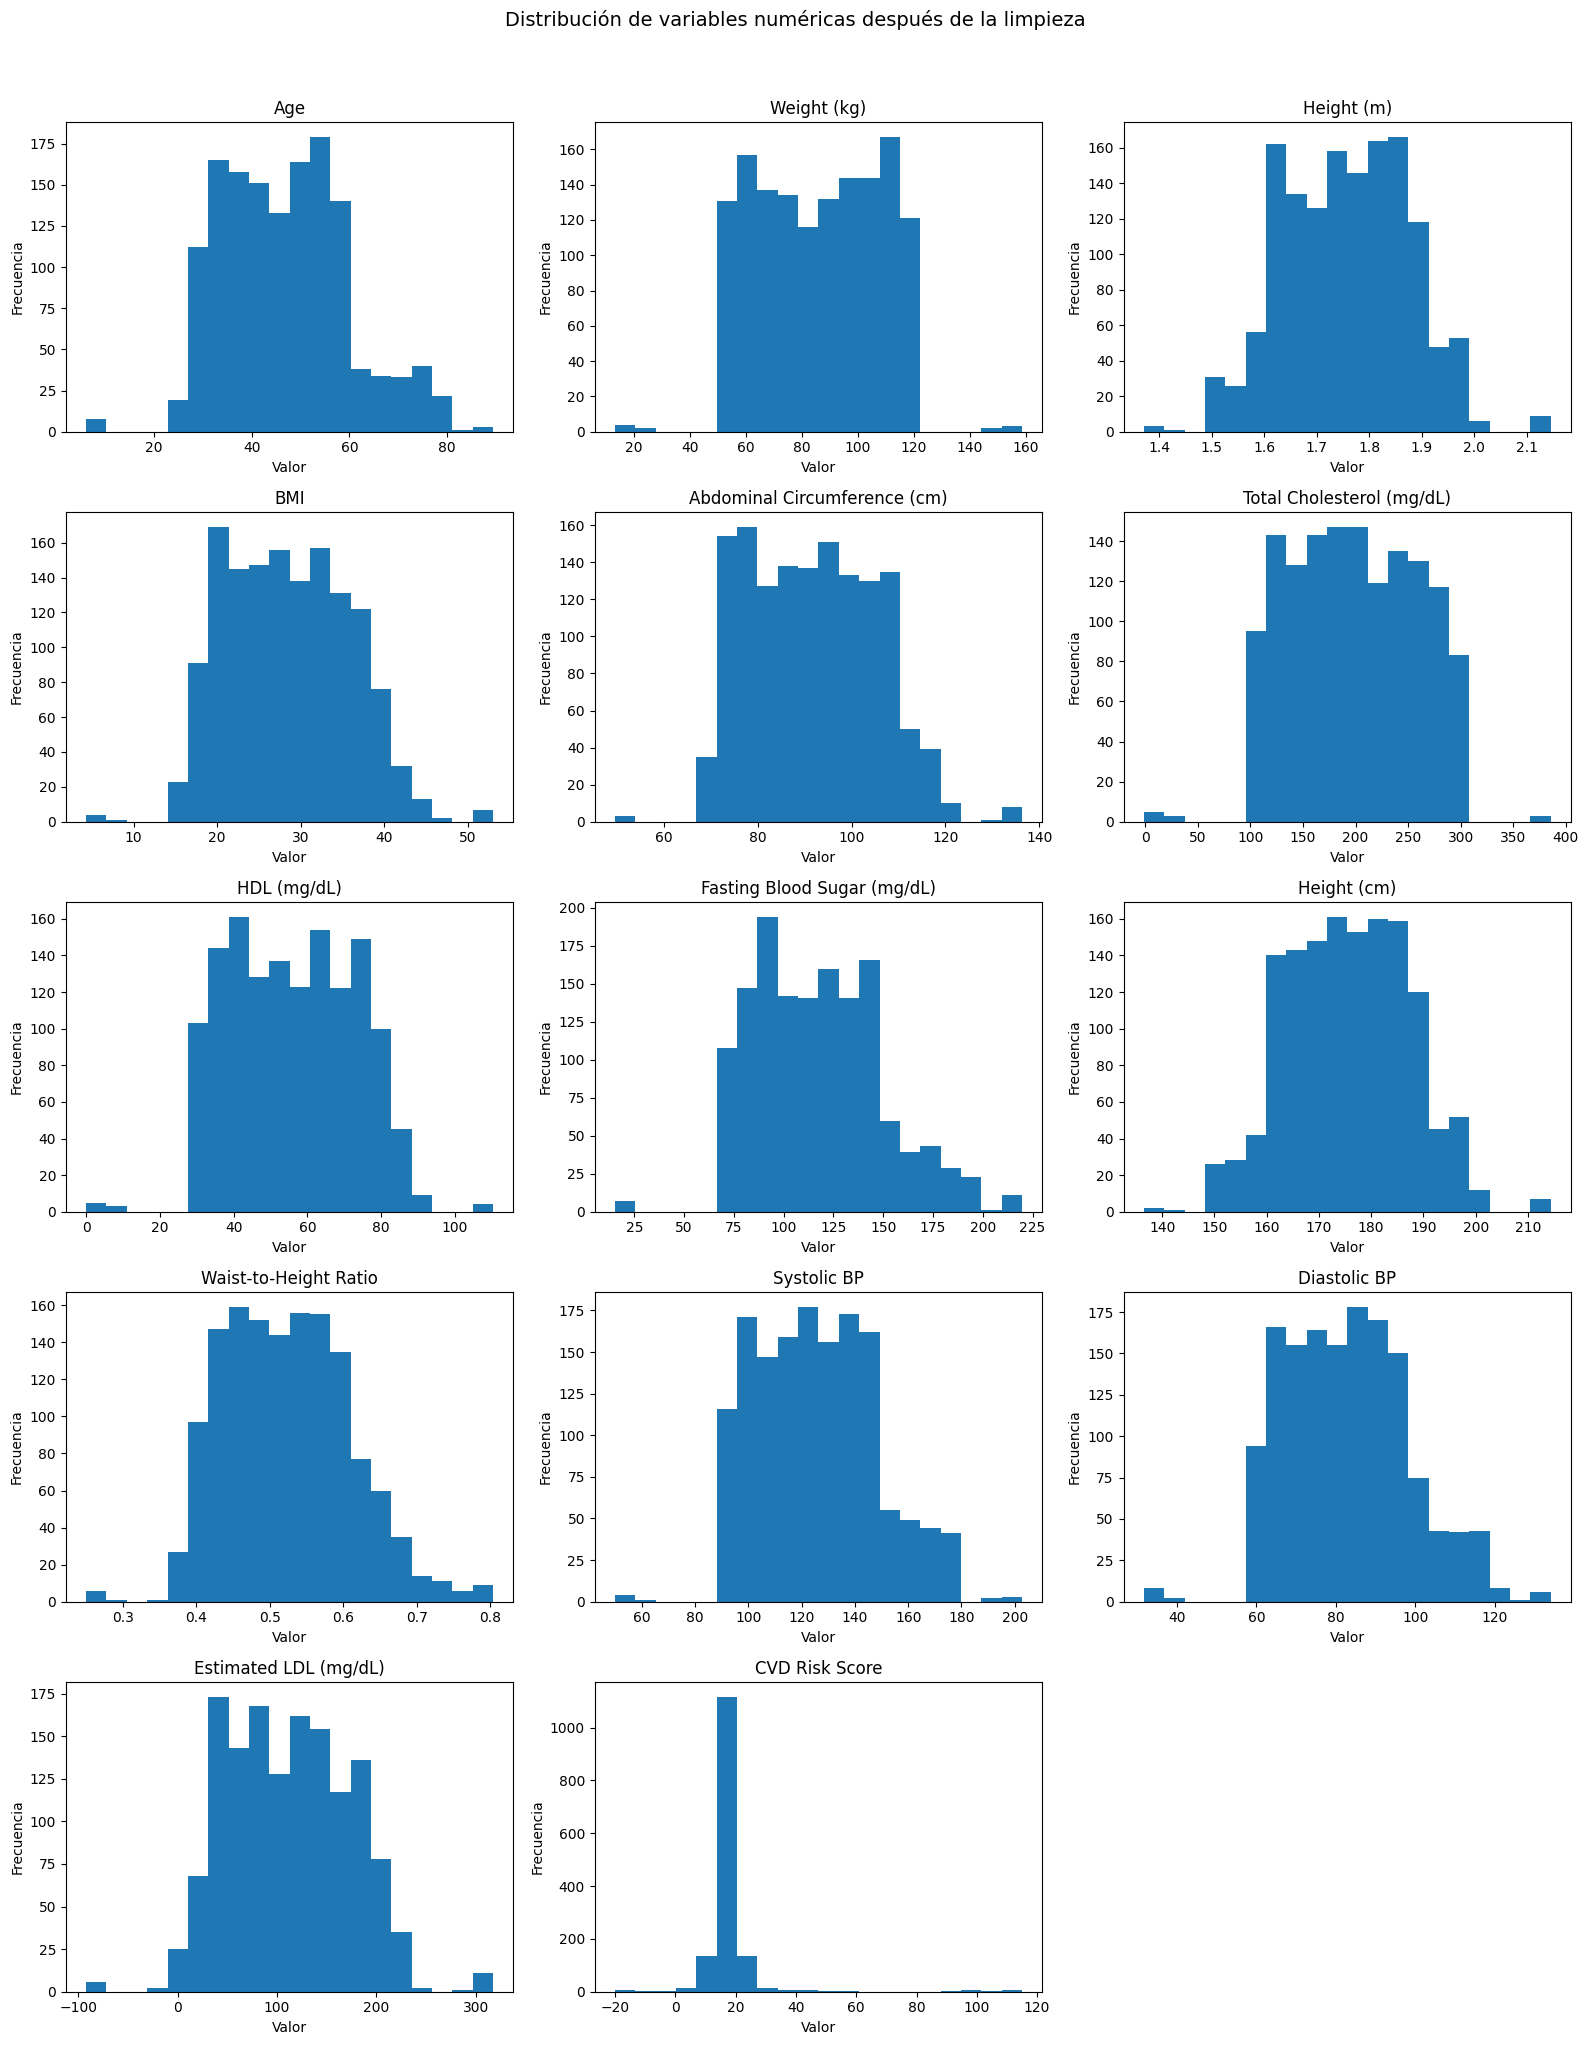

In [56]:
# =========================
# 2) Histogramas numéricos
# =========================
if len(numeric_cols) > 0:
    n = len(numeric_cols)
    ncols = 3
    nrows = math.ceil(n / ncols)

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(16, 4 * nrows))
    axes = np.array(axes).reshape(-1)

    for i, col in enumerate(numeric_cols):
        ax = axes[i]
        data = pd.to_numeric(df_plot[col], errors="coerce").dropna()

        ax.hist(data, bins=20)
        ax.set_title(col)
        ax.set_xlabel("Valor")
        ax.set_ylabel("Frecuencia")

    # Apagar ejes sobrantes
    for j in range(i + 1, len(axes)):
        axes[j].axis("off")

    plt.suptitle("Distribución de variables numéricas después de la limpieza", y=1.02, fontsize=14)
    plt.tight_layout()
    plt.show()
else:
    print("No hay columnas numéricas para graficar.")

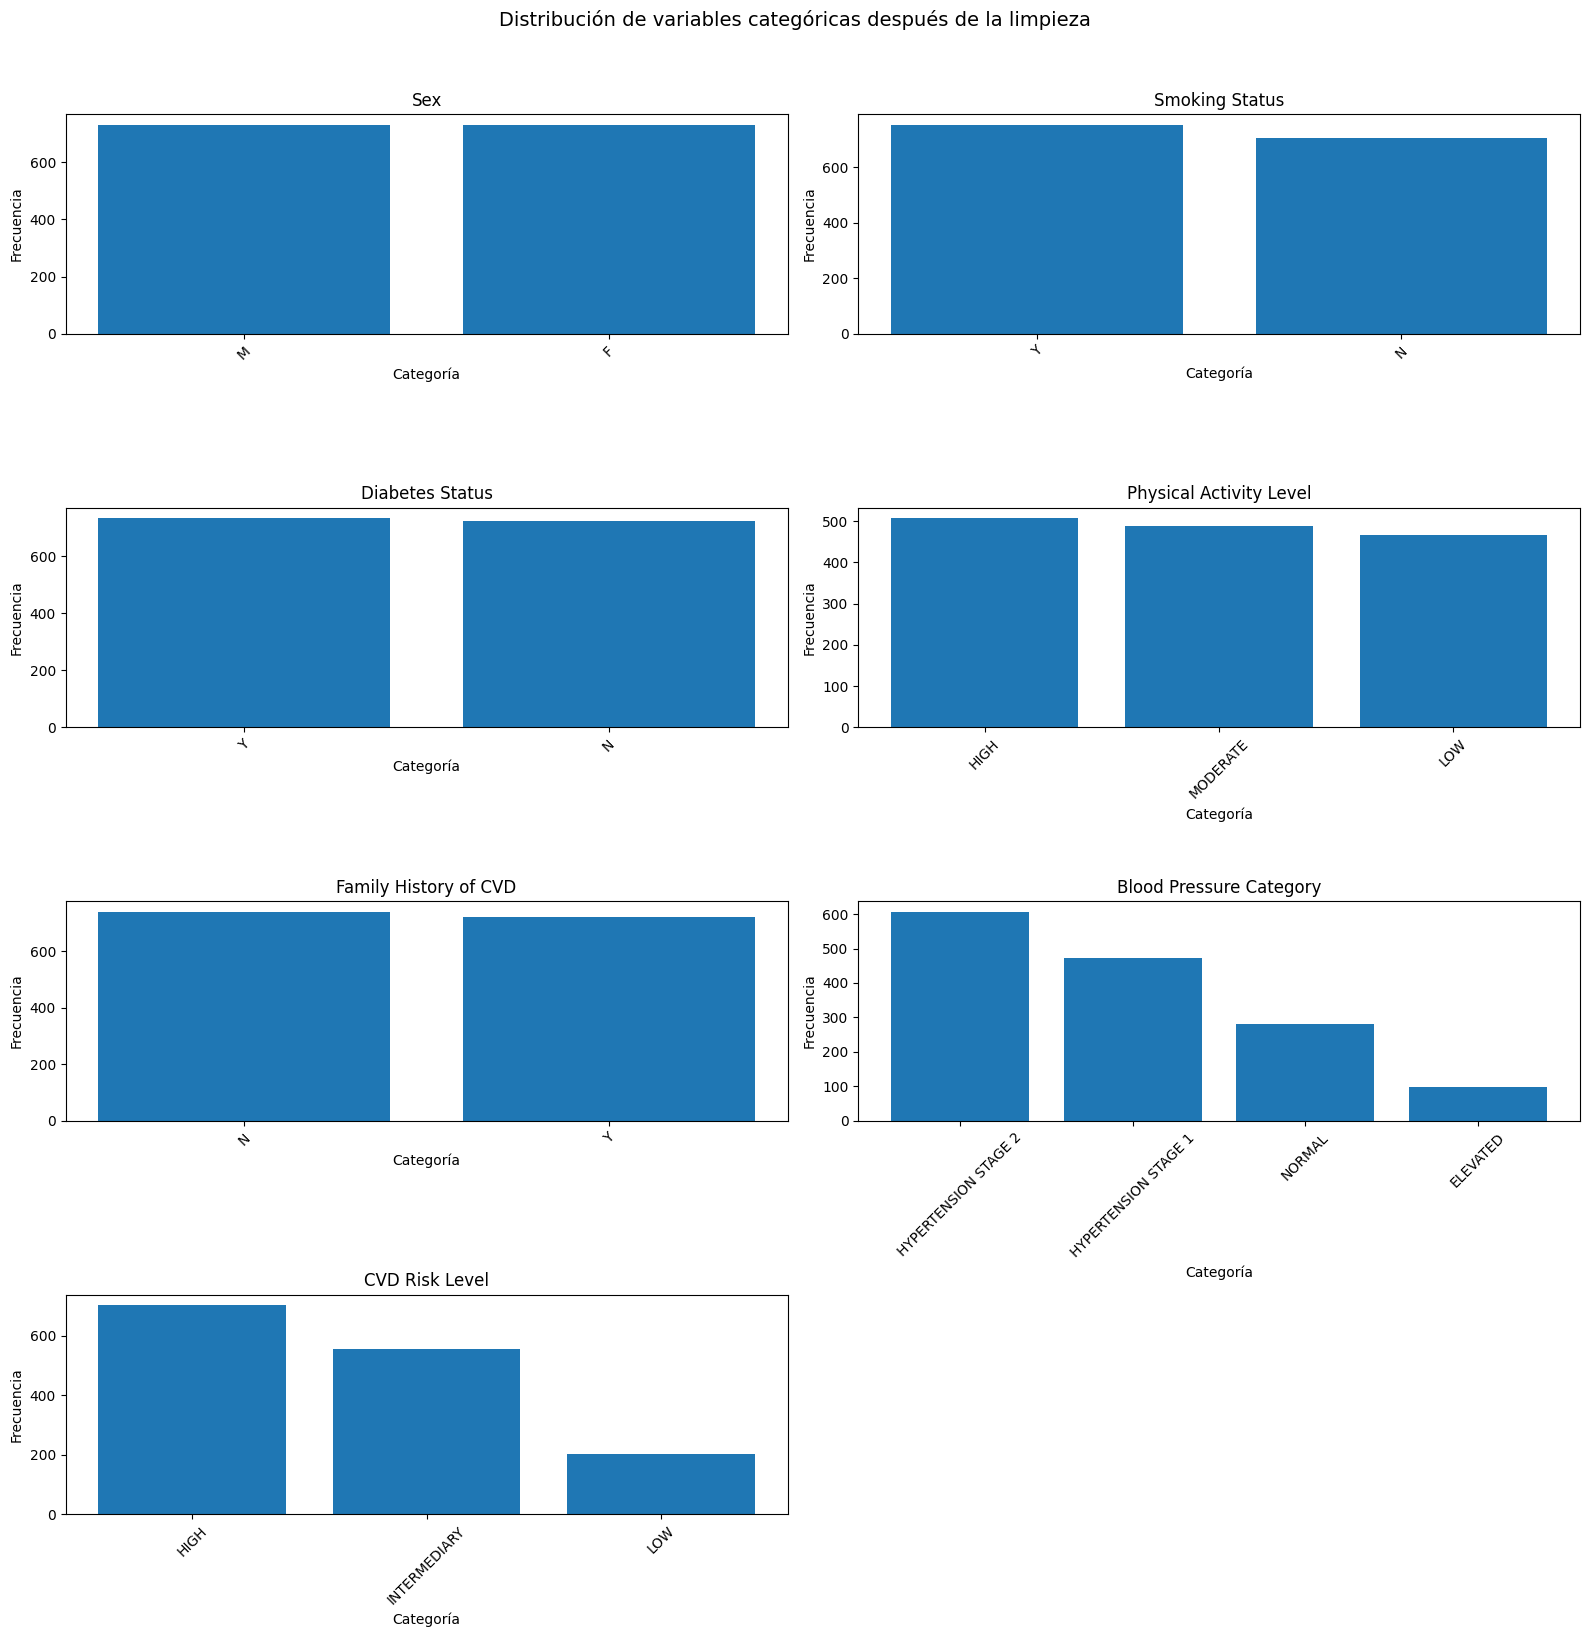

In [57]:
# =========================
# 3) Barras categóricas
# =========================
if len(categorical_cols) > 0:
    n = len(categorical_cols)
    ncols = 2
    nrows = math.ceil(n / ncols)

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(16, 4 * nrows))
    axes = np.array(axes).reshape(-1)

    for i, col in enumerate(categorical_cols):
        ax = axes[i]
        counts = df_plot[col].astype("string").fillna("MISSING").value_counts()

        ax.bar(counts.index.astype(str), counts.values)
        ax.set_title(col)
        ax.set_xlabel("Categoría")
        ax.set_ylabel("Frecuencia")
        ax.tick_params(axis="x", rotation=45)

    # Apagar ejes sobrantes
    for j in range(i + 1, len(axes)):
        axes[j].axis("off")

    plt.suptitle("Distribución de variables categóricas después de la limpieza", y=1.02, fontsize=14)
    plt.tight_layout()
    plt.show()
else:
    print("No hay columnas categóricas para graficar.")

In [58]:
import numpy as np
import pandas as pd

from sklearn.base import BaseEstimator, TransformerMixin

class IQRClipper(BaseEstimator, TransformerMixin):
    def __init__(self, factor=1.5):
        self.factor = factor

    def fit(self, X, y=None):
        X_arr = np.asarray(X, dtype=float)

        self.q1_ = np.nanpercentile(X_arr, 25, axis=0)
        self.q3_ = np.nanpercentile(X_arr, 75, axis=0)
        self.iqr_ = self.q3_ - self.q1_

        self.lower_ = self.q1_ - self.factor * self.iqr_
        self.upper_ = self.q3_ + self.factor * self.iqr_

        return self

    def transform(self, X):
        X_arr = np.asarray(X, dtype=float).copy()
        X_arr = np.clip(X_arr, self.lower_, self.upper_)
        return X_arr

In [59]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, r2_score

RANDOM_STATE = 42

# Separar columnas numéricas y categóricas
numeric_features = X_train.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = X_train.select_dtypes(exclude=[np.number]).columns.tolist()

print("Numéricas:", numeric_features)
print("Categóricas:", categorical_features)

# OneHot compatible con varias versiones de sklearn
try:
    ohe = OneHotEncoder(handle_unknown="ignore", drop="if_binary", sparse_output=False)
except TypeError:
    ohe = OneHotEncoder(handle_unknown="ignore", drop="if_binary", sparse=False)

# ---------- Pipeline base (sin tratar outliers) ----------
numeric_base = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("poly", PolynomialFeatures(degree=2, include_bias=False)),
    ("scaler", StandardScaler()),
])

categorical_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", ohe),
])

preprocess_base = ColumnTransformer(
    transformers=[
        ("num", numeric_base, numeric_features),
        ("cat", categorical_pipe, categorical_features),
    ],
    remainder="drop"
)

model_base = Pipeline(steps=[
    ("preprocess", preprocess_base),
    ("model", LinearRegression()),
])

# ---------- Pipeline con tratamiento de outliers ----------
numeric_outliers = Pipeline(steps=[
    ("clip", IQRClipper(factor=1.5)),
    ("imputer", SimpleImputer(strategy="median")),
    ("poly", PolynomialFeatures(degree=2, include_bias=False)),
    ("scaler", StandardScaler()),
])

preprocess_outliers = ColumnTransformer(
    transformers=[
        ("num", numeric_outliers, numeric_features),
        ("cat", categorical_pipe, categorical_features),
    ],
    remainder="drop"
)

model_outliers = Pipeline(steps=[
    ("preprocess", preprocess_outliers),
    ("model", LinearRegression()),
])

# Split de validación simple para comparar
X_tr, X_te, y_tr, y_te = train_test_split(
    X_train, y_train, test_size=0.2, random_state=RANDOM_STATE
)

# Ajustar y evaluar modelo base
model_base.fit(X_tr, y_tr)
pred_base = model_base.predict(X_te)

rmse_base = root_mean_squared_error(y_te, pred_base)
mae_base = mean_absolute_error(y_te, pred_base)
r2_base = r2_score(y_te, pred_base)

# Ajustar y evaluar modelo con outliers
model_outliers.fit(X_tr, y_tr)
pred_out = model_outliers.predict(X_te)

rmse_out = root_mean_squared_error(y_te, pred_out)
mae_out = mean_absolute_error(y_te, pred_out)
r2_out = r2_score(y_te, pred_out)

comparison = pd.DataFrame({
    "Modelo": ["Base", "Con tratamiento de outliers (IQR clipping)"],
    "RMSE": [rmse_base, rmse_out],
    "MAE": [mae_base, mae_out],
    "R2": [r2_base, r2_out],
})

comparison

Numéricas: ['Age', 'Weight (kg)', 'Height (m)', 'BMI', 'Abdominal Circumference (cm)', 'Total Cholesterol (mg/dL)', 'HDL (mg/dL)', 'Fasting Blood Sugar (mg/dL)', 'Height (cm)', 'Waist-to-Height Ratio', 'Systolic BP', 'Diastolic BP', 'Estimated LDL (mg/dL)']
Categóricas: ['Sex', 'Smoking Status', 'Diabetes Status', 'Physical Activity Level', 'Family History of CVD', 'Blood Pressure Category']


,Modelo,RMSE,MAE,R2
0,Base,10.903284,4.791906,-0.145980
1,Con tratamiento de outliers (IQR clipping),10.926991,4.789972,-0.150969
